# 1 - bifacialVF approach

This jupyter journal will walk us through the creation of the most basic fixed-tilt simulation possible with bifacialvf for agrivoltaics
We will simulate a 1-up landscape system over a grass albedo and look at the ground irradiance from the start of 1 row to the other.


In [5]:
from pathlib import Path
import os
import bifacialvf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pvlib

# IO Files
testfolder = 'TEMP' 
if not os.path.exists(testfolder):
    os.makedirs(testfolder)

In [6]:
# This information helps with debugging and getting support :)
import sys, platform
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("Numpy version ", np.__version__)
print("Pvlib version: ", pvlib.__version__)
print("bifacialVF version ", bifacialvf.__version__)

Working on a  Windows 10
Python version  3.10.15 | packaged by conda-forge | (main, Sep 20 2024, 16:26:40) [MSC v.1941 64 bit (AMD64)]
Pandas version  2.2.3
Numpy version  2.1.1
Pvlib version:  0.11.1
bifacialVF version  0.1.9


In [7]:
plt.rcParams['timezone'] = 'Etc/GMT+7'
font = {'family' : 'DejaVu Sans',
'weight' : 'bold',
'size'   : 22}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = (12, 5)

In [8]:
writefiletitle = os.path.join(testfolder, 'Results_bifacialVF.csv')

module_slope = 2            # m
# Variables
lat = 35.0844              # Albuquerque, NM, Coords.
lon = -106.6504             # Albuquerque, NM Coords.
tilt = 30                   # PV tilt (deg)
sazm = 180                  # PV Azimuth(deg) or tracker axis direction
albedo = None               # Calculated in previous section from SRRL data. Value is 0.28 up to 11/18/19o
clearance_height =1.5/module_slope            #1.5m / 2m collector width. View factor is normalized
# hub_height = 1.5/module_slope # for tracking, distance from ground to modules at the center of the module/pile
pitch = 2/0.35/module_slope              # 1 / 0.35 where 0.35 is gcr --- row to row spacing in normalized panel lengths. View factor is normalized
rowType = "interior"        # RowType(first interior last single)
transFactor = 0             # TransmissionFactor(open area fraction)
sensorsy = 12                # sensorsy(# hor rows in panel)   <--> THIS ASSUMES LANDSCAPE ORIENTATION 
PVfrontSurface = "glass"    # PVfrontSurface(glass or ARglass)
PVbackSurface = "glass"     # PVbackSurface(glass or ARglass)
agriPV = True

 # Calculate PV Output Through Various Methods    
# calculateBilInterpol = False   # Only works with landscape at the moment.
# calculatePVMismatch = False
# portraitorlandscape='portrait'   # portrait or landscape
# cellsnum = 72
# bififactor = 1.0

# Tracking instructions
tracking=False
backtrack=True # doesn't matter if tracking is false
limit_angle = 50 # doesn't matter if not tracking

In [9]:
# Download and Read input
TMYtoread=bifacialvf.getEPW(lat=lat,lon=lon, path = testfolder)
myTMY3, meta = bifacialvf.readInputTMY(TMYtoread)
deltastyle = 'TMY3'
#myTMY3 = myTMY3.iloc[0:24].copy()  # Simulate just the first 24 hours of the data file for speed on this example

path = C:\Users\y_pom\Desktop\inspire\InSPIRE\Studies\UNM_AgrivoltaicsPipeline\InputExamples\TEMP
Making path: EPWs
Getting weather file: USA_NM_Albuquerque.723650_TMY2.epw
 ... OK!


In [10]:
meta

{'loc': 'LOCATION',
 'city': 'ALBUQUERQUE',
 'state-prov': 'NM',
 'country': 'USA',
 'data_type': 'TMY2-23050',
 'WMO_code': '723650',
 'latitude': 35.05,
 'longitude': -106.62,
 'TZ': -7.0,
 'altitude': 1619.0}

In [11]:
bifacialvf.simulate(myTMY3, meta, writefiletitle=writefiletitle, 
         tilt=tilt, sazm=sazm, pitch=pitch, clearance_height=clearance_height , 
         rowType=rowType, transFactor=transFactor, sensorsy=sensorsy, 
         PVfrontSurface=PVfrontSurface, PVbackSurface=PVbackSurface, 
         albedo=albedo, tracking=tracking, backtrack=backtrack, 
         limit_angle=limit_angle, deltastyle=deltastyle, agriPV=agriPV)


Calculating Sun position with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Using albedo from TMY3 file.
Note that at the moment, no validation check is done in the albedo data, so we assume it's correct and valid.

 
********* 
Running Simulation for TMY3: 
Location:   ALBUQUERQUE
Lat:  35.05  Long:  -106.62  Tz  -7.0
Parameters: tilt:  30   Sazm:  180     Clearance_Height :  0.75   Pitch:  2.857142857142857   Row type:  interior   Albedo:  None
Saving into TEMP\Results_bifacialVF.csv
 
 
Distance between rows for no shading on Dec 21 at 9 am solar time =  1.1334118610468977
Actual distance between rows =  1.9911174533584184
 
Saving Ground Irradiance Values for AgriPV Analysis. 


  0%|                                                                                         | 0/8760 [00:00<?, ?it/s]C:\Users\y_pom\anaconda3\envs\inspire\lib\site-packages\bifacialvf\bifacialvf.py:459: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  albedo = myTMY3.Alb[rl]
100%|█████████████████████████████████████████████████████████████████████████████| 8760/8760 [00:57<00:00, 153.47it/s]

Finished


In [12]:
#Load the results from the resultfile
from bifacialvf import loadVFresults
(data, metadata) = loadVFresults(writefiletitle)

## Looking and plotting at the results 

In [22]:
data.set_index(pd.to_datetime(data['date']), inplace=True, drop=True)
data.index = data.index.map(lambda t: t.replace(year=2021))   # Chagning to be the same year


In [26]:
#groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True).astype(float)
#data = data.map(lambda x: float(x) if isinstance(x, np.float64) else x)
# Splitting and converting the ground irradiance values
groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True)

groundIrrads = groundIrrads.map(lambda x: float(x.replace('np.float64(', '').replace(')', '')) if isinstance(x, str) else x)


In [28]:
df = groundIrrads.groupby([pd.Grouper(freq='ME')]).sum().T
# I'm sure there's a fancier way to do this but hey, this works.
df.rename(columns={ df.columns[0]: "Jan", df.columns[1]: "Feb",df.columns[2]: "Mar", df.columns[3]: "Apr",
                   df.columns[4]: "May",df.columns[5]: "June",df.columns[6]: "July",df.columns[7]: "Aug",
                   df.columns[8]: "Sept",df.columns[9]: "Oct",df.columns[10]: "Nov",df.columns[11]: "Dec"    }, inplace = True)

Text(0, 0.5, 'Cumulative Insolation for the month [kWh/m2]')

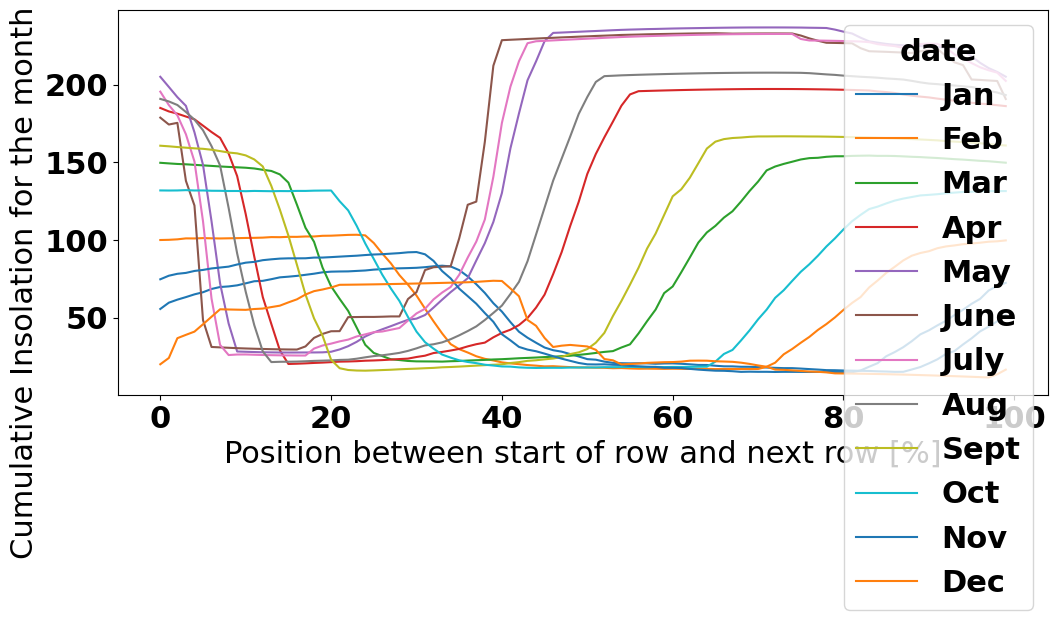

In [29]:
fig = (df/1000).plot()
fig.set_xlabel('Position between start of row and next row [%]')
fig.set_ylabel('Cumulative Insolation for the month [kWh/m2]')

In [31]:
monthlyGHI = pd.DataFrame(data['ghi'].groupby([pd.Grouper(freq='ME')]).sum())

In [32]:
monthlyGHI['Month'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
monthlyGHI.set_index(monthlyGHI['Month'], inplace=True)
monthlyGHI = monthlyGHI.drop(columns='Month')

In [33]:
df_norm = df.T
df_norm = df_norm.div(monthlyGHI['ghi'], axis=0)
df_norm = df_norm.T

Text(0, 0.5, 'Normalized Insolation for the month/GHI')

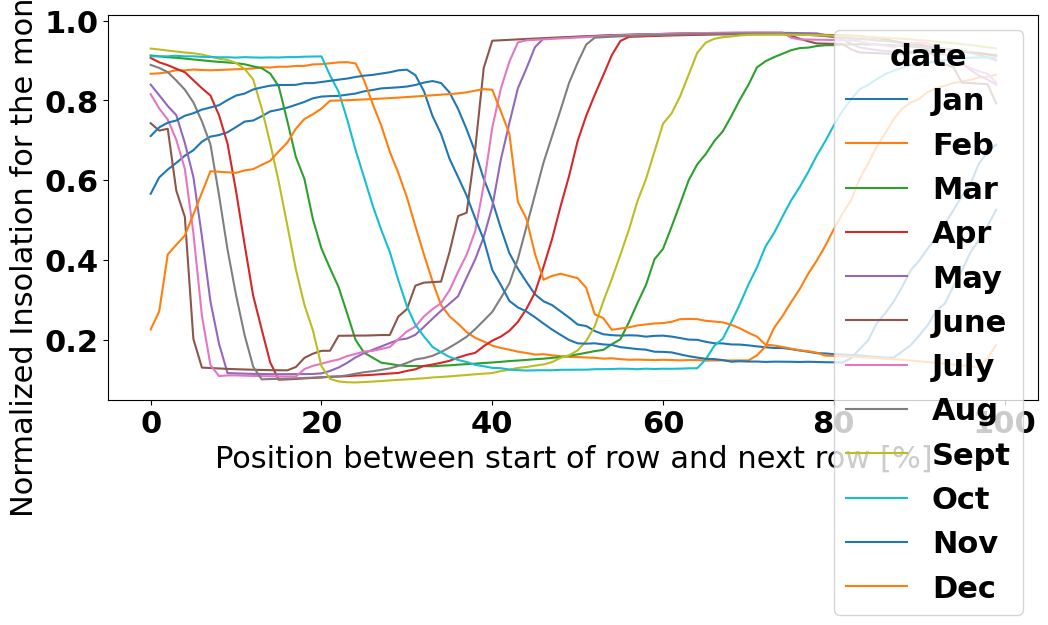

In [34]:
fig = (df_norm).plot()
fig.set_xlabel('Position between start of row and next row [%]')
fig.set_ylabel('Normalized Insolation for the month/GHI')